# Fashion MNIST image recognition
## Yijing Xiao

## https://www.kaggle.com/zalando-research/fashionmnist

In the last blog post, I implemented an Convolutional Neural Network (CNN) for MNIST digit recognition task. I was surprised by how powerful CNN is on image recognition task. This time, I found another dataset similar to MNIST, named [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [6]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

- Data preparation

In [2]:
data = pd.read_csv("fashion-mnist_train.csv")
data.head()
image_size = data.iloc[:, 1:].values.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
image_width
num_data = data.shape[0]
num_train_data = int(num_data * 0.9)
train_data = data.iloc[:num_train_data]
dev_data = data.iloc[num_train_data:]

First of all, before we do anything on the dataset, let's plot some images to see how the Fashion MNIST dataset looks like. 

In [3]:
def showImage(image,ax=None):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    if len(image.shape) > 1:
        n=image.shape[0]
    else:
        n=int(np.sqrt(image.shape[0]))
        image = image[-n**2:]
        image = image.reshape(n,n)

    if ax==None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')

Different from MNIST, fashion MNIST are images of fashion products like shoes, clothes, etc. It is fun to classify something more sophisticated than handwritten digits, isn't it? 

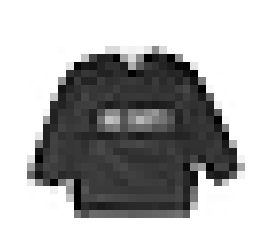

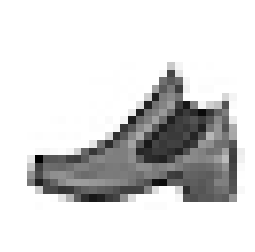

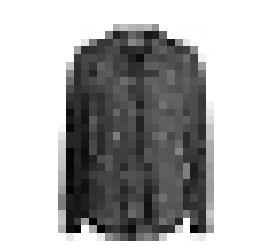

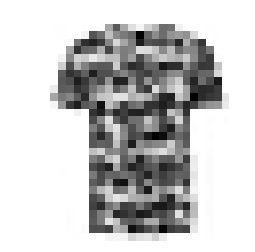

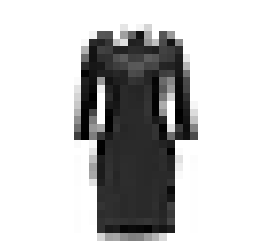

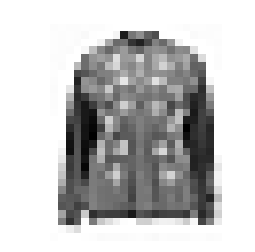

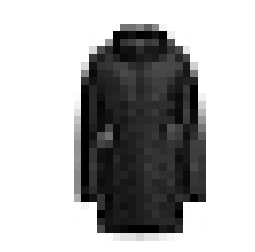

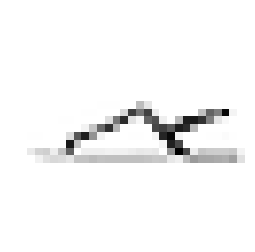

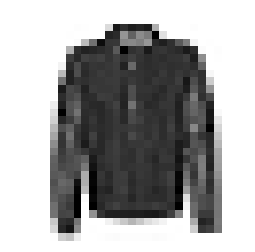

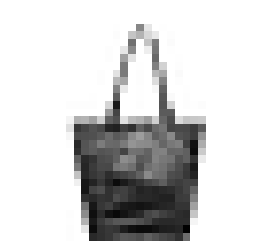

In [10]:
for i in range(10):
    showImage(train_data.values[i])

## Standard Convolutional Neural Network 

borrowed from https://github.com/pytorch/examples/blob/master/mnist/main.py


Again, as a first experiment, I would like to try the exact CNN model I used in MNIST classification task. 

In [4]:
BATCH_SIZE = 32
def eval(model, data):
    '''
        args:
            data: 42000 * 785 matrix
            
    '''
    model.eval()
    correct_count = 0.
    total_count = 0.
    for i in range(0, data.shape[0], BATCH_SIZE):
        batch_data = data.iloc[i:i+BATCH_SIZE, :].values
        x = batch_data[:, 1:] # 32 * 784
        y = batch_data[:, 0] # 32
        x = Variable(torch.from_numpy(x), volatile=True).float()
        y = Variable(torch.from_numpy(y), volatile=True)
        pred = model(x)
        loss = F.nll_loss(pred, y)
        correct_count += torch.sum(torch.max(pred, 1)[1] == y).data[0]
        total_count += batch_data.shape[0]
    return correct_count, total_count
        

In [5]:
# define a neural network, convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(x.size(0), 1, int(image_height), int(image_width)) # B * 1 * 28 * 28
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # B * 10 * 12 * 12
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # B * 20 * 4 * 4
        x = x.view(-1, 320) 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

# instantiate the model
model = Net()

In [7]:
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_acc = 0.
# start training
for epoch in range(20):
    model.train()
    for i in range(0, train_data.shape[0], BATCH_SIZE):
        batch_data = train_data.iloc[i:i+BATCH_SIZE, :].values
        x = batch_data[:, 1:] # 32 * 784
        y = batch_data[:, 0] # 32
        x = Variable(torch.from_numpy(x)).float()
        y = Variable(torch.from_numpy(y))
        pred = model(x)
        optimizer.zero_grad()
        loss = F.nll_loss(pred, y)
        loss.backward()
        optimizer.step()
    correct_count, total_count = eval(model, dev_data)
    acc = correct_count / total_count
    print("dev acc: {}".format(acc))
    if acc > best_acc:
        best_acc = acc
        print("save the model")
        torch.save(model.state_dict(), "model.th")
    else:
        learning_rate *= 0.8
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

dev acc: 0.5635
save the model
dev acc: 0.5233333333333333
dev acc: 0.5848333333333333
save the model
dev acc: 0.569
dev acc: 0.6726666666666666
save the model
dev acc: 0.6953333333333334
save the model
dev acc: 0.7225
save the model
dev acc: 0.7158333333333333
dev acc: 0.732
save the model
dev acc: 0.7426666666666667
save the model
dev acc: 0.7485
save the model
dev acc: 0.7471666666666666
dev acc: 0.7515
save the model
dev acc: 0.7585
save the model
dev acc: 0.7606666666666667
save the model
dev acc: 0.757
dev acc: 0.7725
save the model
dev acc: 0.7723333333333333
dev acc: 0.7695
dev acc: 0.7785
save the model


In [8]:
model.load_state_dict(torch.load("model.th"))
test_data = pd.read_csv("fashion-mnist_test.csv")
correct_count, total_count = eval(model, test_data)
print("test acc: {}".format(correct_count/total_count))

test acc: 0.7734


The result seems to be much worse than MNIST classification task, which is reasonable, as this is indeed a more difficult task than digit classification. In next blog post I want to try some methods to improve the recognition accuracy. 